### 参考链接
https://www.cnblogs.com/zingp/p/10375691.html

https://blog.csdn.net/liangyihuai/article/details/78811664

### 正则化的理解：
正则化的原理就是，在损失函数后面加一个正则项系数，
l1正则项是在加上参数的和的绝对值，
l2正则项是加上参数平方和的开平方根

目的都是在正则项约束的情况下，在反向传播过程中找到最优的损失，
在求损失的时候，w训练参数是已经固定的，所以在二维上（也就是训练参数是两个的时候，l1正则项的函数图像是正方形，l2则是圆形）
这样就很好理解，很多博客上说的，相交点。

加入正则项还有一个超参数这里引用博客的内容
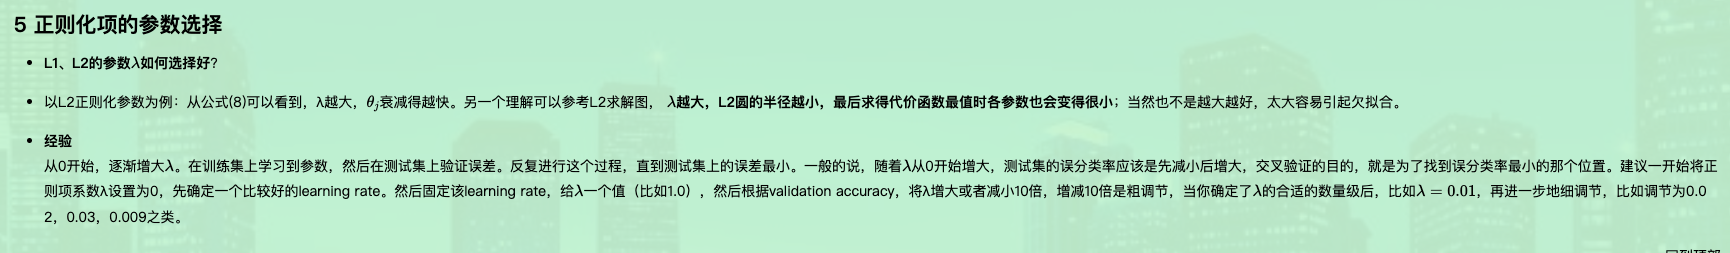

### 链接代码实现
https://www.cnblogs.com/NPC-assange/p/11360497.html

In [1]:
# L1

regularization_loss = 0
for param in model.parameters():
    regularization_loss+=torch.sum(abs(param))

for epoch in range(EPOCHS):
    y_pred = model(x_train)
    classify_loss = criterion(y_pred, y_train.float().view(-1, 1))
    loss = classify_loss + 0.001 * regularization_loss  # 引入L1正则化项

In [2]:
import torch

In [ ]:
criterion  = torch.nn.BCELoss() #定义损失函数
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0, dampening=0,weight_decay=0) #weight_decay 表示使用L2正则化 默认0 不开启



In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn.init as init
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np

import pandas as pd

%matplotlib inline

In [2]:
data = pd.read_csv("./data/data.txt")
x, y = data.iloc[:,:8],data.iloc[:,-1]

In [3]:
# x,y

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = Variable(torch.from_numpy(np.array(x_train)).float())
y_train = Variable(torch.from_numpy(np.array(y_train).reshape(-1, 1)).float())    
x_test = Variable(torch.from_numpy(np.array(x_test)).float())
y_test= Variable(torch.from_numpy(np.array(y_test).reshape(-1,1)).float())

In [5]:
# x_test,y_test

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(8,200)
        self.l2 = nn.Linear(200,50)
        self.l3 = nn.Linear(50,1)
    
    def forward(self, x):
        out1 = F.relu(self.l1(x))
        out2 = F.dropout(out1, p = 0.5)
        out3 = F.relu(self.l2(out2))
        out4 = F.dropout(out3, p=0.5)
        y_pred = F.sigmoid(self.l3(out4))
        return y_pred
    

In [14]:
def l1_regularization(model, l1_alpha):
    l1_loss = []
    for module in model.modules():
        if type(module) is nn.BatchNorm2d:
            l1_loss.append(torch.abs(module.weight).sum())
    return l1_alpha * sum(l1_loss)

def l2_regularization(model, l2_alpha):
    l2_loss = []
    for module in model.modules():
        if type(module) is nn.Conv2d:
            l2_loss.append((module.weight ** 2).sum() / 2.0)
    return l2_alpha * sum(l2_loss)


In [12]:
model = Model()

In [16]:
from tqdm import tqdm
criterion = torch.nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr =0.001,weight_decay=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)
Loss = []
regularization_loss = 0
for epoch in tqdm(range(2000)):
    y_pred = model(x_train)
    classify_loss = criterion(y_pred, y_train)

    for param in model.parameters():
        # if param.requires_grad:
        regularization_loss += torch.sum(abs(param))
    
    loss = classify_loss + 0.001 * regularization_loss  # 引入L1正则化项
   
   
    if epoch % 400==0:
        Loss.append(loss)
    optimizer.zero_grad()
    # loss.backward(retain_graph=True)
    loss.backward()
    optimizer.step()
    
def label_flag(data):
    for i in range(len(data)):
        if data[i]>0.5:
            data[i]=1.0
        else:data[i]=0.0
    return data

y_pred = label_flag(y_pred)  
print(classification_report(y_train.detach().numpy(), y_pred.detach().numpy()))


# 测试
y_test_pred = model(x_test)
y_test_pred = label_flag(y_test_pred)       
print(classification_report(y_test.detach().numpy(), y_test_pred.detach().numpy()))

  0%|          | 1/2000 [00:00<00:51, 38.65it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.